In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
import utils, models
import torch.nn.functional as F
import math
import random
import gpytorch

/home/toni/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def install_package(package):
    import sys
    !{sys.executable} -m pip install package

In [3]:
training_set = pd.read_csv("Data/training_set.csv")
training_set_metadata = pd.read_csv("Data/training_set_metadata.csv")

print(training_set.shape, training_set_metadata.shape)

(1421705, 6) (7848, 12)


In [4]:
data_obj, label = utils.load_passbands_list(path = "Data/Data_as_h5/obj_passbands.h5", objid = 615, path_enter = "Data/")

In [5]:
data_obj[0].shape

torch.Size([63, 2])

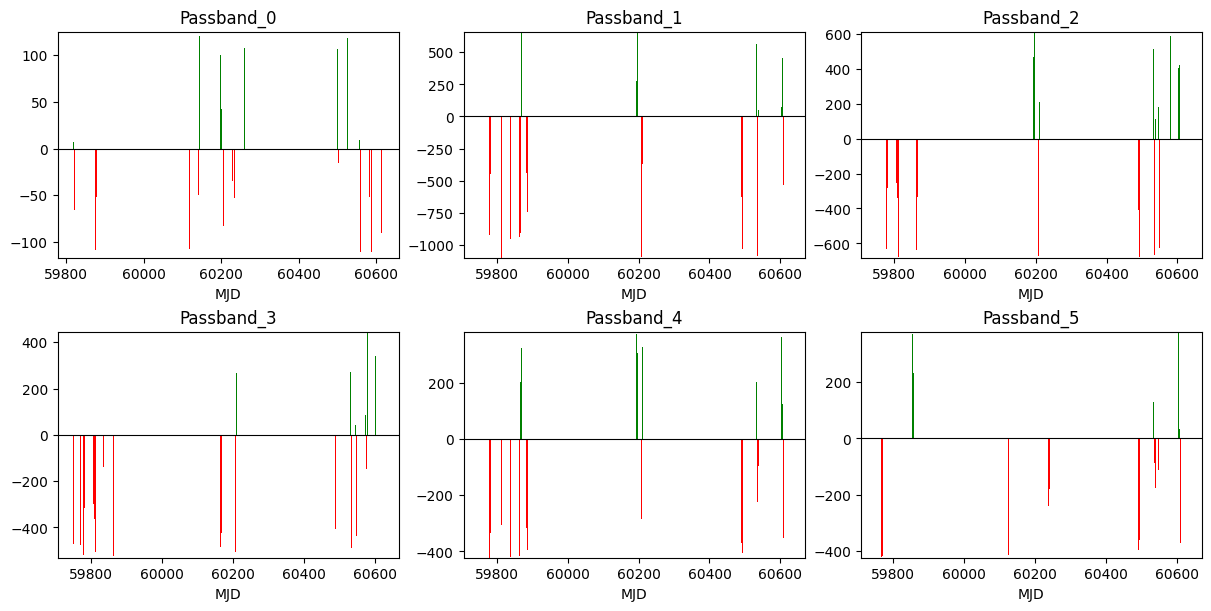

In [6]:
utils.plot_passbands(data_obj)

In [7]:
data_obj_preprocessed = utils.preprocess_data_obj(data_obj = data_obj)
print(data_obj_preprocessed.shape)

torch.Size([2, 352, 6])


# Interpolation of passbands

In [ ]:
plt.scatter(data_obj[0][:,0:1], data_obj[0][:,1:2], s = 1)
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

time_series = data_obj[0].numpy()

time = time_series[:, 0:1]
feature = time_series[:, 1:2]

# Create new time vector filling the gaps
N = 100 # Amount of points to fill.
new_time = []
for i in range(1, time.shape[0]):
    added_time = np.linspace( time[i-1] + (time[i] - time[i-1]), time[i] - (time[i] - time[i-1]), N )
    new_time.append( added_time )
new_time = np.concatenate(new_time, axis = 0)

## Create the new array of features that will be filled with original values or NaN's.
#new_features = []
#for i in range(new_time.shape[0]):
#    if (time == new_time[i]).sum() == 1:
#        new_features.append( float(feature[ time == new_time[i] ]) )
#    else:
#        new_features.append( np.nan )
#new_features = np.array(new_features).reshape(-1,1)

In [ ]:
time = data_obj[0][:,0:1].flatten()
feature = data_obj[0][:,1:2].flatten()

In [ ]:
time_scaled = (time - torch.min(time)) / (torch.max(time) - torch.min(time))
feature_scaled = (feature - feature.mean(dim=0)) / feature.std(dim=0)

feature_scaled

In [ ]:
plt.scatter(time_scaled, feature_scaled, s = 1)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 141.11it/s]


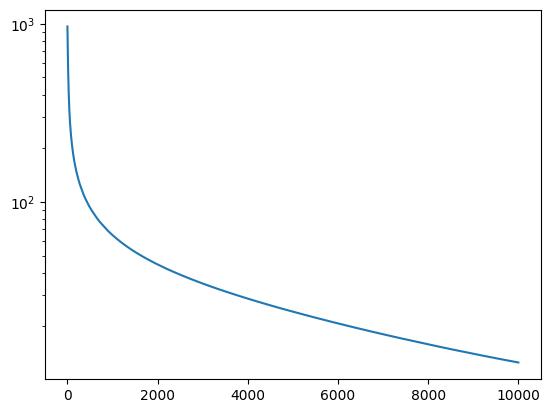

In [138]:
# Define the GPyTorch ExactGP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel() + gpytorch.kernels.RBFKernel() + gpytorch.kernels.RQKernel()
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x = time.flatten(), train_y = feature.flatten(), likelihood = likelihood)

# Set the model to training mode and initialize hyperparameters
model.train()
likelihood.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Optimize the model
loss_hist = []
num_iterations = 10000
for i in tqdm( range(num_iterations) ):
    optimizer.zero_grad()
    output = model(time.flatten())
    loss = -mll(output, feature.flatten())
    loss.backward()
    loss_hist.append( float( loss.detach().cpu().numpy() ) )
    optimizer.step()

# Plot the loss function
plt.semilogy(loss_hist)
plt.show()

In [141]:
new_time_tensor = torch.tensor(new_time, dtype = torch.float32).flatten()

print(new_time_tensor.shape)
print(new_time_tensor)

new_time_tensor_sorted = new_time_tensor[np.argsort(new_time_tensor)]

new_time_tensor_scaled = (new_time_tensor_sorted - torch.min(time)) / (torch.max(time) - torch.min(time))

print(new_time_tensor.shape)

time_sort = time[np.argsort(time)]
feature_sort = feature[np.argsort(time)]

torch.Size([1118])
tensor([59710.4141, 59710.4141, 59711.2930,  ..., 60587.1602, 60588.0391,
        60588.0391])
torch.Size([1118])


/tmp/ipykernel_1154521/2916276381.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_time_tensor = torch.tensor(new_time, dtype = torch.float32).flatten()


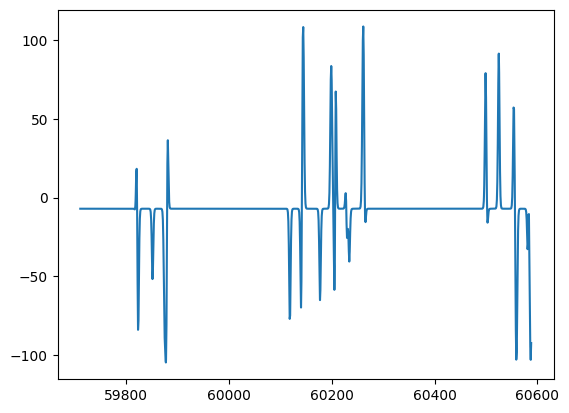

In [142]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = new_time_tensor_sorted
    observed_pred = likelihood( model(test_x) )

MultipleKernel_pred = observed_pred

# Plot
plt.plot( test_x, observed_pred.mean )
plt.show()

In [ ]:
plt.plot(time_sort, feature_sort)
plt.show()

In [ ]:
plt.plot(time_sort, feature_sort_scaled)
plt.show()

In [133]:
N = 1000

times_obj = torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 )
times_obj = (times_obj.flatten())[ torch.argsort( times_obj.flatten() ) ].view(-1,1)

min_time, max_time = torch.min(times_obj), torch.max(times_obj)

times_obj_extra = torch.linspace(min_time, max_time, N).view(-1,1)

new_time = torch.cat( (times_obj, times_obj_extra), dim = 0 )
new_time = (new_time.flatten())[ torch.argsort( new_time.flatten() ) ].view(-1,1)

# Specify the passband
passband = 0

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = models.ExactGPModel(train_x = data_obj[passband][:,0:1].flatten(), train_y = data_obj[passband][:,1:2].flatten(), likelihood = likelihood)

observed_pred = utils.train_GP_and_eval(model = model, data_obj = data_obj, passband = passband, new_time = new_time, likelihood = likelihood, num_iterations = 1000)

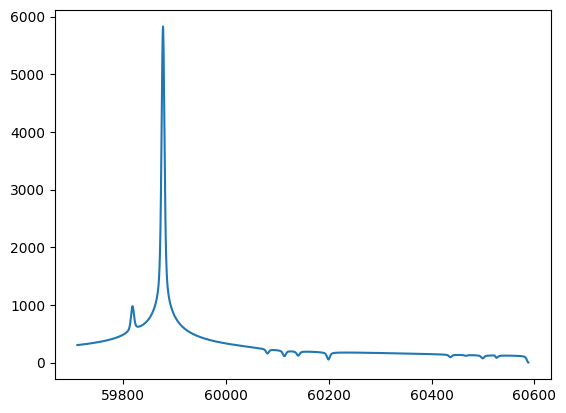

In [134]:
plt.plot(new_time, observed_pred)
plt.show()

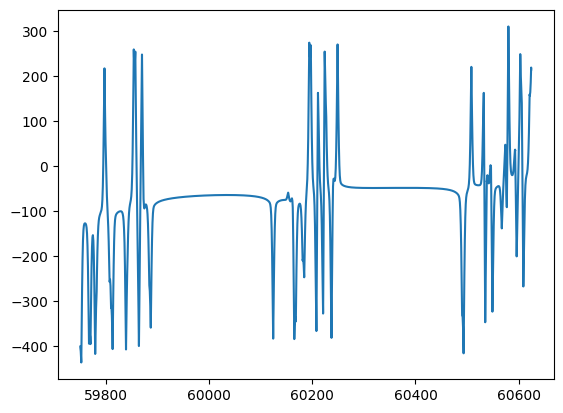

In [16]:
plt.plot(new_time, observed_pred)
plt.show()

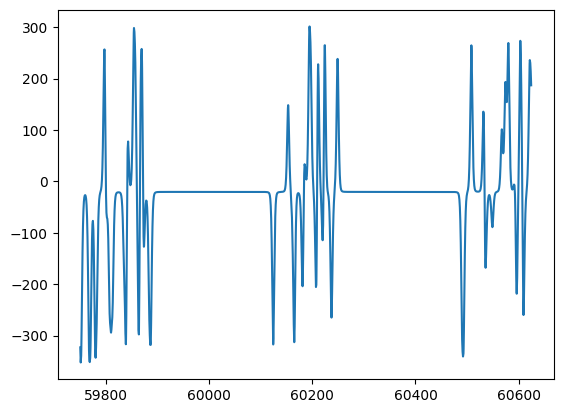

In [18]:
plt.plot(new_time, observed_pred)
plt.show()

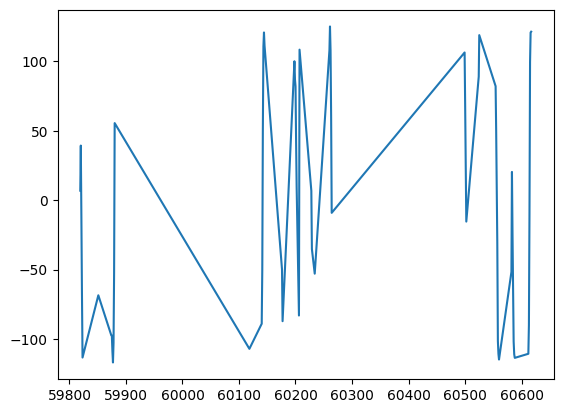

In [23]:
times_obj = (data_obj[0][:,0:1].flatten())[ torch.argsort( data_obj[0][:,0:1].flatten() ) ].view(-1,1)
features_sorted = (data_obj[0][:,1:2].flatten())[ torch.argsort( data_obj[0][:,0:1].flatten() ) ].view(-1,1)

plt.plot(times_obj, features_sorted)
plt.show()

# Traditional interpolation

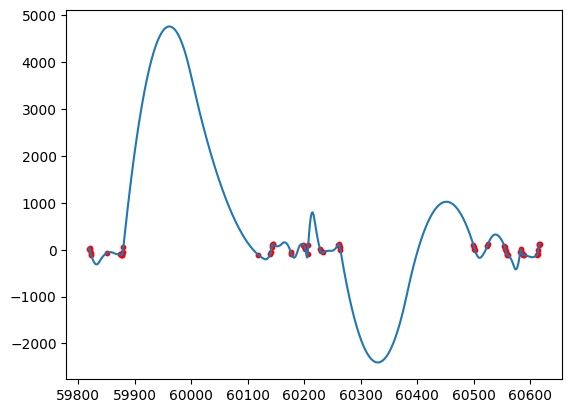

In [60]:
from scipy.interpolate import interp1d

time, feature = data_obj[0][:,0:1], data_obj[0][:,1:2]
sorted_time = (time.flatten())[ torch.argsort( time.flatten() ) ].view(-1,1)
sorted_feature = (feature.flatten())[ torch.argsort( time.flatten() ) ].view(-1,1)

min_time, max_time = torch.min(time), torch.max(time)
new_time = torch.linspace(min_time, max_time, 1000)

interp_feature = interp1d( sorted_time.flatten().numpy(), sorted_feature.flatten().numpy(), kind="quadratic" )( new_time.flatten().numpy() )

plt.plot( new_time.flatten().numpy(), interp_feature )
plt.scatter( sorted_time.flatten().numpy(), sorted_feature.flatten().numpy(), s = 10, color = "red" )
plt.show()

# Gaussian interpolation

/home/toni/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/toni/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 2.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/toni/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


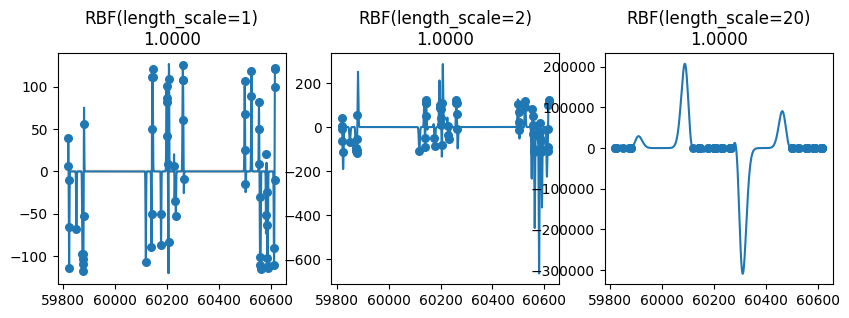

In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k

xs, ys = sorted_time.flatten().numpy(), sorted_feature.flatten().numpy()
x_fine = new_time.flatten().numpy()

kernels = [
    k.RBF(length_scale=1.0, length_scale_bounds=(1.0, 1.01)), 
    k.RBF(length_scale=2.0, length_scale_bounds=(2.0, 2.01)),
    k.RBF(length_scale=20.0, length_scale_bounds=(20.0, 20.01)),
]

# Make some axes please
fig, axes = plt.subplots(figsize=(10, 3), ncols=len(kernels), sharey=False)

for kernel, ax in zip(kernels, axes):
    # Fit the GP, which doesnt do much as we fixed the length_scale
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    # The 2D and [:, None] stuff is because the object expects 2D data in, not 1D
    y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

    ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
    ax.set_title(f"{kernel}\n{y_std.max():0.4f}")

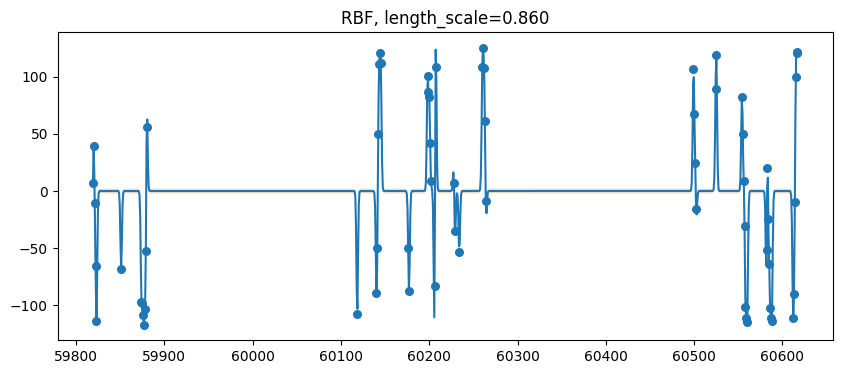

In [113]:
kernel = k.RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0))

gp = GaussianProcessRegressor(kernel = kernel)
gp.fit(np.atleast_2d(xs).T, ys)
y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

# Plot it all, yay
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
ax.plot(x_fine, y_mean)
ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
ax.set_title(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}");
# Note that the fitted kernel is inside the GP, the original kernel won't be modified.
plt.show()

In [130]:
# First, extract minimum and maximum times from all the entire data

training_set = pd.read_csv("Data/training_set.csv")
training_set_metadata = pd.read_csv("Data/training_set_metadata.csv")

print(training_set.shape, training_set_metadata.shape)

obj_ids = training_set_metadata["object_id"].values.tolist()

min_times, max_times = [], []

for i in tqdm(range( len(obj_ids) ) ):
    data_obj, label = utils.load_passbands_list(path = "Data/Data_as_h5/obj_passbands.h5", objid = obj_ids[i], path_enter = "Data/")
    min_times.append( float( torch.min( torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 ).flatten() ) ) )
    max_times.append( float( torch.max( torch.cat( [ obj[:,0:1] for obj in data_obj ], dim = 0 ).flatten() ) ) )

general_min, general_max = np.min(min_times), np.max(max_times)

print("Total minimum time: ", general_min)
print("Total maximum time: ", general_max)

(1421705, 6) (7848, 12)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7848/7848 [01:55<00:00, 68.01it/s]

Total minimum time:  59580.03515625
Total maximum time:  60674.36328125


In [ ]:
# Specify an object
i = 0
# Now, go through all the passbands and adjust the models